# Import python libraries

and our own functions to load data, preprocessing steps, utilities and wrapper functions to calculate Green's functions, elastic love numbers from both FORTRAN code and elastimated with neural network

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS, Predictive
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    detrend,
    ffnn_input_vector,
    interval_outlier,
    load_thickness_time_series,
)
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import FFNN, compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)


def compute_error(trues, predicted):
    """
    From course material
    """
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues) ** 2))
    return corr, mae, rae, rmse

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


Load uplift data from two GNET (Greenland GPS Network) stations and height data from Kuaqalissuaq glacier. The time series from GNET and height data from ISSM are sampled weekly. The height data is further preprocessed with an interval outlier removal method to remove unrealistic peaks.

In [6]:
df_em = default_em()

lmax = 512
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift(timefreq="W")
df = df.set_index("Time")
df_tmp = df.copy()
# df_tmp = df_tmp.set_index("Time")
df.Thickness = (
    interval_outlier(df_tmp, M_step=24, max_std=2)
    .Thickness.interpolate()
    .fillna(method="bfill")
    .values
)

height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
df_em

/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


df_em (DataFrame Earth Model) describes different earth parameters required for a FORTRAN program called e_clovers to compute elastic love numbers. We want to uptimise only for the elastic contribution, which is the instantanious response for the solid earth. The most interesting parameter to look at is rigidity. Rigidity is a parameter which describes how easily an elastic plate can be bend. A larger value corresponds to a stiffer plate. We only optimise for the first 60km of the lithosphere. 

The height data is compared to the uplift measured at the GNET station.



## Visualize the data

The time series are visualized to inspect the GNET and glacier height data.

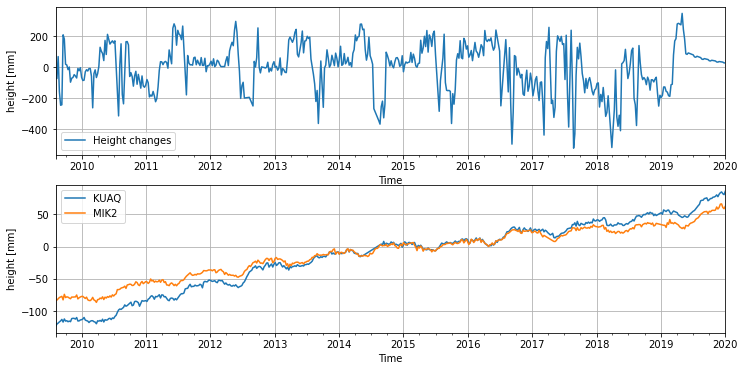

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
df.Thickness.plot(ax=ax[0])
ax[0].set_ylabel("height [mm]")
ax[0].legend(["Height changes"])
ax[0].grid()

df.Up_kuaq.plot(ax=ax[1])
df.Up_mik2.plot(ax=ax[1])
ax[1].set_ylabel("height [mm]")
ax[1].legend(["KUAQ", "MIK2"])
ax[1].grid()
plt.show()

We are interested in modeling the seasonal variations in the time series. The Green's function shown in report is a scaling factor on the height data. We can therefore Roughly estimate this parameter and show the similarities of the glacier height data and detrended GNET time series.



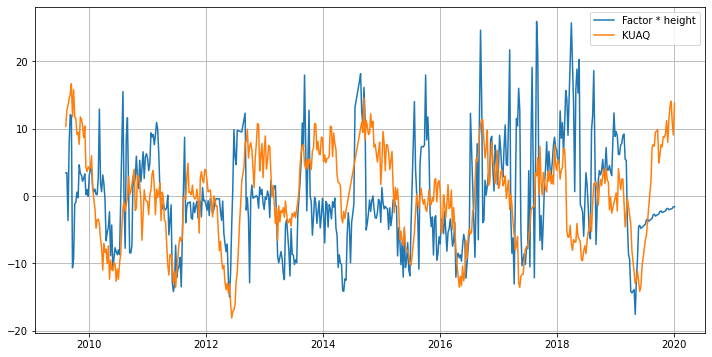

In [9]:
plt.figure(figsize=(12,6))
#gf_test = -2e-4
tmp = height - np.mean(height)  # / np.std(height)
tmp2 = detrend(df.Up_kuaq.values)
tmp2 = tmp2 - np.mean(tmp2)  # / np.std(tmp2)
plt.plot(df.index, -0.05 * tmp, label="Factor * height")
plt.plot(df.index, tmp2, label ="KUAQ")
plt.legend()
plt.grid()
plt.show()

By a quick inspection of the data from KUAQ GNET station and the glacier height data multiplied by a factor, seasonal patterns are clearly seen. The GNET station has an amplitide of 10-20mm a year!

The FORTRAN code to calculate the elastic love numbers and hence the Green's function is computational expensive. We want to find the least amount of spherical harmonics coefficients possible where the solution is stable.

In [10]:
gf_1 = []
gf_2 = []
append_1 = gf_1.append
append_2 = gf_2.append
llmax = [2**i for i in np.arange(7, 12)]
# [128, 256, 512, 1024, 2048]
for lmax in llmax:
    print(lmax)
    # lmax = 512
    lmin = 0
    lstep = 1
    CONF = {
        "EARTH_FILE": "earth_M3L70V01c.txt",
        "COMPRESS": "1",
        "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
        "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
    }
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)

    append_1(
        greens_function(
            hlove,
            nlove,
            [68.704665, -33.214577],
            [68.58700000, -33.05270000],
            arsurf=80e3 * 80e3,
        )
    )
    append_2(
        greens_function(
            hlove,
            nlove,
            [68.704665, -33.214577],
            [68.14029705, -31.45179999],
            arsurf=80e3 * 80e3,
        )
    )

128
256
512
1024
2048


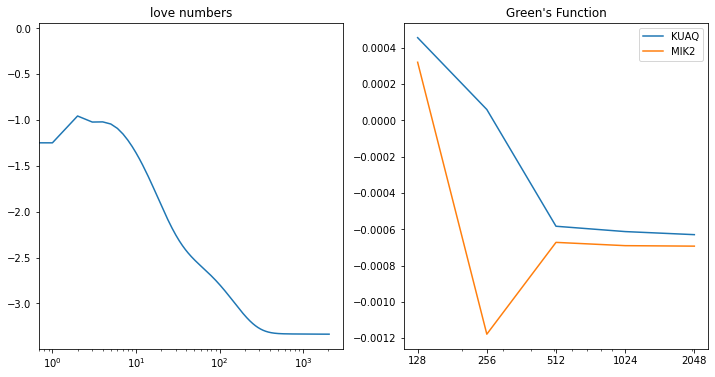

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].semilogx(hlove)
ax[0].set_title("love numbers")

ax[1].semilogx(llmax, gf_1, label="KUAQ")
ax[1].semilogx(llmax, gf_2, label="MIK2")
ax[1].set_xticks(ticks=llmax)
ax[1].set_xticklabels(labels=llmax)
ax[1].set_title("Green's Function")
ax[1].legend()
plt.show()

From the plot above can it be seen that the elastic love numbers and the Green's function converge to a constant with at least 512 harmonic coefficients. The default Earth model have been used in this example. From the Green's function plot can it also be seen that the scaling factor for MIK2 is less than for KUAQ. This is a natural consequence of MIK2 GNET station is further away from the glacier.

### Prepare data and split in train / test
The data prepared here includes does not only the first model, but all later models as well. But what data is accessed depends on the chapter/model. This can be seen as how our work has progressed throughout project.

In [ ]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [ ]:
standardized_height = height - np.mean(height) / np.std(height)
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X_train = torch.tensor(X_cat).float()
y_train = torch.tensor(y_train).float()
y_train = (y_train - y_train.mean()) / y_train.std()
len(X_train)

In [14]:
def model(X, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(N)))

    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1
    )
    rigidity_1 = 1e11 + 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)

    # rigidity layer 2
    loc, scale = 4, 0.5
    rigidity_dist_2 = IntervalFoldedDistribution(
        dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1
    )
    rigidity_2 = 1e11 + 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)

    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1.item()
    df_em["rigidity"][1] = rigidity_2.item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=CONF, verbose=0)

    # Draw Greens Function
    gf = pyro.deterministic(
        "gf",
        torch.tensor(
            greens_function(
                hlove,
                nlove,
                [68.704665, -33.214577],
                [68.58700000, -33.05270000],
                arsurf=80e3 * 80e3,
            )
        ),
    )

    # Draw target
    with pyro.plate("data"):
        w = pyro.sample(
            "w", dist.Normal(-gf * X[:, 0], sigma_w), obs=obs
        )  # 1e5 is a scaling constant

    return w

In [15]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=20, warmup_steps=10, num_chains=1)
mcmc.run(X_train, y_train, df_em)

Warmup:  33%|██████████████▎                            | 10/30 [18:24, 205.62s/it, step size=3.41e-02, acc. prob=0.610]                  

KeyboardInterrupt: 

In [14]:
# Show summary of inference results
mcmc.summary()  # exclude_deterministic=False


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  rigidity_1      1.56      0.59      1.49      0.77      2.63     10.85      0.98
  rigidity_2      3.90      0.48      3.79      3.23      4.57     94.07      0.98
    sigma[0]      2.66      1.89      1.98      0.99      5.21   1029.86      0.95
    sigma[1]      2.35      1.14      2.05      1.14      4.96     37.60      0.98
    sigma[2]      1.58      0.75      1.17      0.84      2.71     35.66      0.95
    sigma[3]      2.51      2.23      2.02      0.71      7.05     52.01      0.98
    sigma[4]      1.80      2.15      1.47      0.44      2.46     19.29      1.01
    sigma[5]      1.24      0.72      1.29      0.29      2.44     15.91      1.06
    sigma[6]      1.53      1.59      0.74      0.18      5.27     28.92      0.95
    sigma[7]      1.30      0.70      0.91      0.54      2.26     33.76      0.96
    sigma[8]      2.79      2.26      2.53      0.38      7.59     30.15      0.95
   

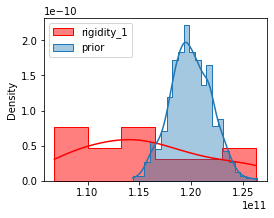

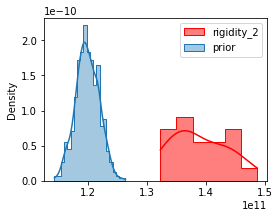

In [15]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]

rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4, 3))
    sns.histplot(
        1e11 + 1e10 * samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
    )
    plt.legend()
    plt.show()

#### Get deterministic part out

In [17]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, y_train, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

gf: (20, 1)
w: (20, 126)


In [18]:
gf_res, w_res = predictive.items()
gf_res, w_res = gf_res[1], w_res[1]

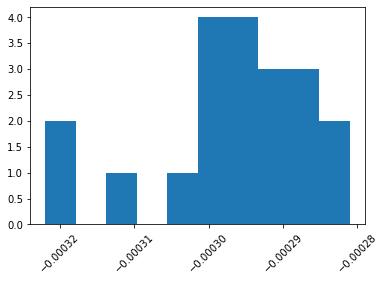

In [19]:
plt.hist(gf_res.numpy())
plt.xticks(rotation=45);

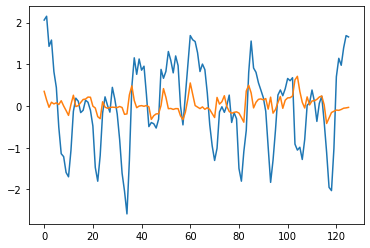

In [25]:
w_pred = (gf_res * X_train[:, 0]).mean(axis=0)
plt.plot(y_train)
plt.plot(w_pred)